In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import re
import sys
from pathlib import Path
from src.scorer import exact_match
from openai import OpenAI
import os

In [ ]:
project_root = Path("..").resolve()
if str(project_root) not in sys.path:
    sys.path.append(str(project_root))


In [ ]:
client = OpenAI(api_key=os.getenv("OPENAI_API_KEY"))


In [5]:
df = pd.read_csv("results_raw.csv")
df.head()


,prompt,group,question,answer,gold
0,baseline,A,Is Rome the capital of Italy?,"Yes, Rome is the capital of Italy.",Yes
1,baseline,A,Is Paris in Italy?,"No, Paris is not in Italy. Paris is the capita...",No
2,baseline,A,Is water wet?,"The question ""Is water wet?"" depends on how yo...",Yes
3,baseline,A,Is fire cold?,"No, fire is not cold. Fire is hot because it i...",No
4,baseline,A,Is the Earth round?,"Yes, the Earth is round. More specifically, it...",Yes


In [ ]:
df["score"] = df.apply(
    lambda r: exact_match(r["answer"], r["gold"],client),
    axis=1
)


df.to_csv("results_scored.csv", index=False)

In [7]:
prompt_accuracy = df.groupby("prompt")["score"].mean()
prompt_accuracy


prompt
baseline    0.950000
clear       0.933333
cot         0.933333
verify      0.916667
y_n         0.933333
Name: score, dtype: float64

In [8]:
group_prompt_accuracy = (
    df.groupby(["group", "prompt"])["score"]
    .mean()
    .unstack()
)

group_prompt_accuracy


prompt,baseline,clear,cot,verify,y_n
group,,,,,
A,0.9,0.9,0.9,0.9,1.0
B,1.0,1.0,1.0,0.9,1.0
C,1.0,0.9,0.9,0.9,0.9
D,1.0,1.0,1.0,1.0,1.0
E,1.0,1.0,1.0,1.0,1.0
F,0.8,0.8,0.8,0.8,0.7


In [12]:
ordered_prompts = ["baseline", "clear", "cot", "verify", "y_n"]
group_prompt_accuracy = group_prompt_accuracy[ordered_prompts]
group_prompt_accuracy


prompt,baseline,clear,cot,verify,y_n
group,,,,,
A,0.9,0.9,0.9,0.9,1.0
B,1.0,1.0,1.0,0.9,1.0
C,1.0,0.9,0.9,0.9,0.9
D,1.0,1.0,1.0,1.0,1.0
E,1.0,1.0,1.0,1.0,1.0
F,0.8,0.8,0.8,0.8,0.7


Across all question groups, the baseline prompt achieves the highest overall accuracy. This suggests that, when evaluated globally, the language model is already capable of handling a large fraction of the questions without requiring explicit reasoning instructions or output constraints.

The clear, chain-of-thought, and yes/no-constrained prompts yield very similar overall performance, indicating that these strategies neither consistently improve nor degrade performance across heterogeneous tasks.

Interestingly, the verify prompt performs slightly worse on average, despite being designed to reduce reasoning errors. This highlights an important observation: encouraging additional verification does not necessarily lead to higher accuracy when aggregated across tasks of mixed difficulty and structure.

Overall, these results reinforce the idea that no single prompting strategy is universally optimal, and that global averages may obscure important task-dependent effects.

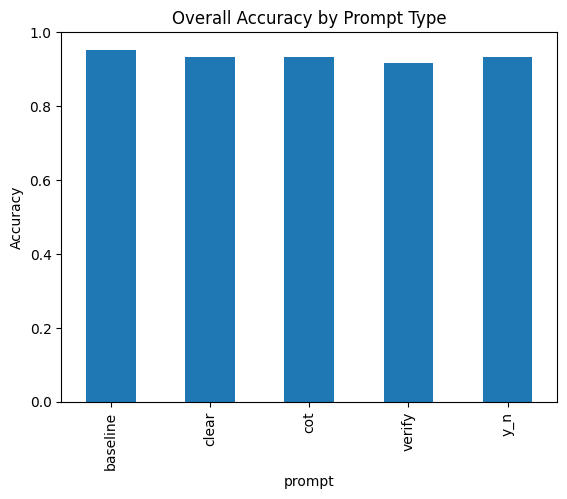

In [9]:
plt.figure()
prompt_accuracy.plot(kind="bar")
plt.ylabel("Accuracy")
plt.title("Overall Accuracy by Prompt Type")
plt.ylim(0, 1)
plt.show()


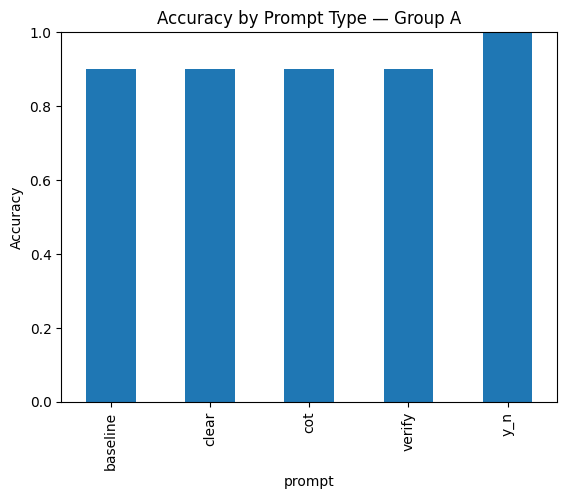

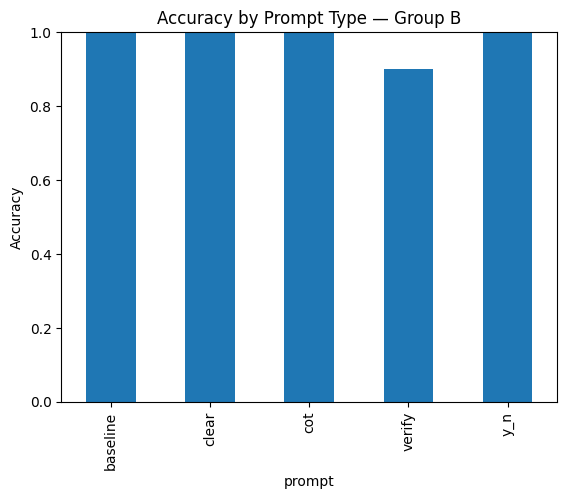

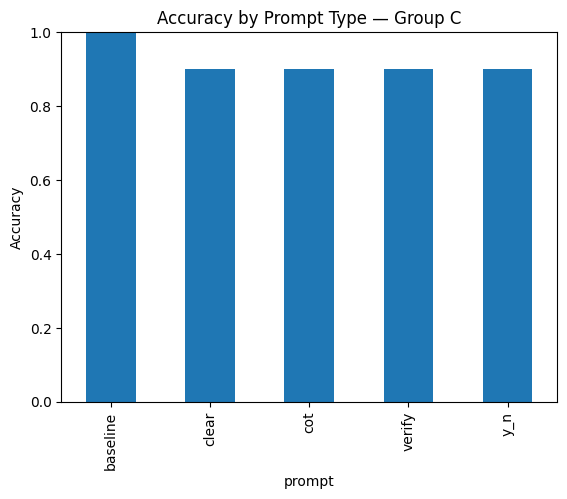

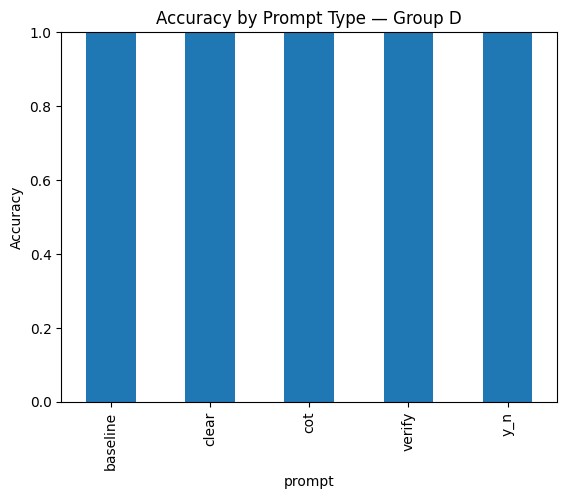

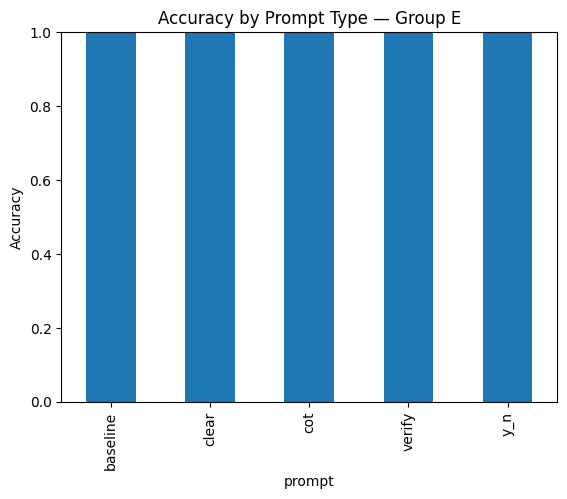

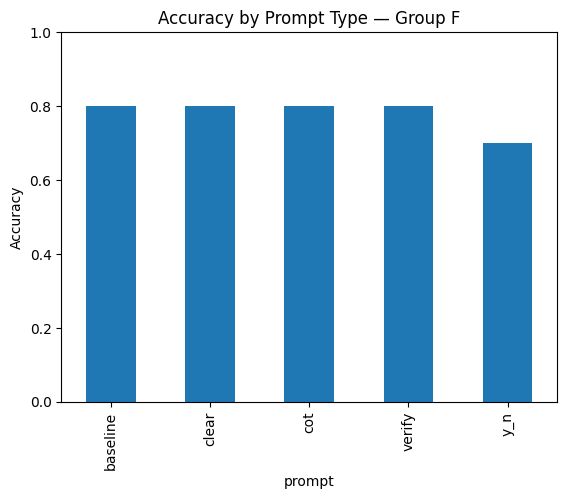

In [11]:
for group in group_prompt_accuracy.index:
    plt.figure()
    group_prompt_accuracy.loc[group].plot(kind="bar")
    plt.title(f"Accuracy by Prompt Type — Group {group}")
    plt.ylabel("Accuracy")
    plt.ylim(0, 1)
    plt.show()


<Figure size 640x480 with 0 Axes>

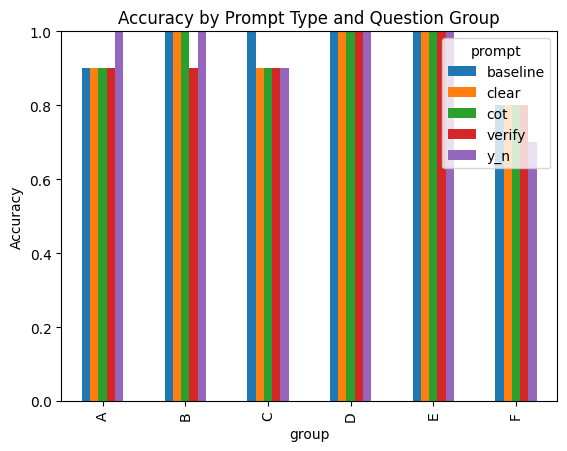

In [10]:
plt.figure()
group_prompt_accuracy.plot(kind="bar")
plt.ylabel("Accuracy")
plt.title("Accuracy by Prompt Type and Question Group")
plt.ylim(0, 1)
plt.show()


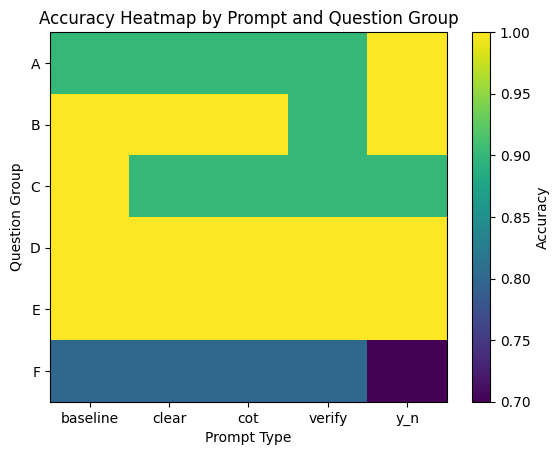

In [14]:
plt.figure()
plt.imshow(group_prompt_accuracy.values, aspect="auto")
plt.colorbar(label="Accuracy")

plt.xticks(range(len(group_prompt_accuracy.columns)), group_prompt_accuracy.columns)
plt.yticks(range(len(group_prompt_accuracy.index)), group_prompt_accuracy.index)

plt.title("Accuracy Heatmap by Prompt and Question Group")
plt.xlabel("Prompt Type")
plt.ylabel("Question Group")

plt.show()

All prompt strategies perform similarly on Group A, with only a marginal advantage for the Yes/No-constrained prompt. This confirms that for simple factual questions, the task is largely insensitive to prompt engineering, and explicit reasoning provides no measurable benefit. This group serves as a sanity check, showing that prompt complexity is unnecessary for trivial questions.

Nearly all prompt strategies achieve perfect accuracy in Group B, with a slight drop for the verify prompt. This suggests that adding self-verification can occasionally introduce unnecessary complexity, leading to overthinking or altered conclusions in otherwise straightforward scenarios. The results indicate that moderate factual difficulty does not require explicit reasoning guidance.

The baseline prompt performs best in this group, while all other strategies exhibit a small but consistent drop. This suggests that additional prompt constraints may interfere with the model’s internal heuristics for conceptual questions, rather than helping them. In particular, reasoning-based prompts do not improve performance, indicating that these questions rely more on conceptual understanding than on step-by-step computation.

All prompt strategies achieve perfect accuracy in Group D. This indicates that, once the misconceptions are well-defined and the evaluation methodology is robust, the model can correctly resolve these questions regardless of prompting style. This group shows that prompt choice becomes irrelevant when the model’s underlying knowledge is strong and unambiguous.

The uniform perfect accuracy across all prompt strategies suggests that the model has strong prior knowledge about these misconceptions, and that prompt engineering does not play a decisive role once evaluation artifacts are removed. This result is particularly important, as it demonstrates that earlier differences observed in misconception-heavy questions were largely due to evaluation bias rather than genuine reasoning failures.

Group F is the most challenging set and the only group where performance drops consistently across all prompts. This confirms that formal reasoning and computation-based questions remain difficult, even for advanced language models. Notably, no prompt strategy clearly outperforms the others, and the Yes/No-constrained prompt performs slightly worse. This suggests that simply forcing binary outputs is insufficient for tasks requiring structured reasoning, and that even explicit chain-of-thought prompting does not guarantee improved accuracy. These findings highlight the intrinsic difficulty of engineering-style reasoning tasks, rather than shortcomings of specific prompt strategies.

Overall accuracy masks important task-dependent effects. Simple and moderate factual questions show minimal sensitivity to prompt design. Conceptual questions may even be negatively affected by additional prompt constraints. Misconception-based questions are handled robustly once evaluation bias is controlled. Engineering and mathematical reasoning questions remain challenging, with no clear winning prompt strategy.
Prompt engineering should be viewed as a task-adaptive design choice rather than a universally beneficial technique

<Figure size 640x480 with 0 Axes>

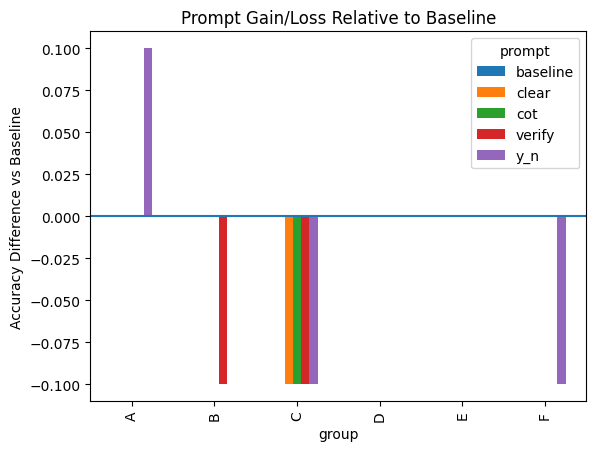

In [15]:
baseline = group_prompt_accuracy["baseline"]

delta = group_prompt_accuracy.subtract(baseline, axis=0)

plt.figure()
delta.plot(kind="bar")
plt.axhline(0)
plt.ylabel("Accuracy Difference vs Baseline")
plt.title("Prompt Gain/Loss Relative to Baseline")
plt.show()


This figure shows the change in accuracy of each prompt strategy relative to the baseline prompt, computed separately for each question group. Positive values indicate an improvement over the baseline, while negative values indicate a degradation.

The results highlight a strong task dependency in the effectiveness of prompt engineering. In Group A, the Yes/No-constrained prompt exhibits a clear positive gain over the baseline, confirming that strict output constraints can be beneficial for simple factual questions. However, this gain does not generalize to more complex settings.

In Groups B and C, most alternative prompts either match or underperform the baseline, with the verify prompt showing a noticeable loss in Group B. This suggests that additional reasoning or self-verification may introduce unnecessary complexity in tasks that the model can already solve reliably.

For Groups D and E, all prompt strategies perform identically to the baseline, resulting in zero relative gain or loss. This indicates that prompt engineering has no measurable effect when the model’s underlying knowledge is strong and unambiguous.

In Group F (engineering and mathematical reasoning), all prompt strategies underperform the baseline, with the Yes/No-constrained prompt showing the largest drop. This suggests that forcing a binary output can be detrimental when tasks require structured reasoning or intermediate computations.

Overall, the figure demonstrates that prompt engineering does not provide consistent gains, and that improvements observed in some groups are offset by losses in others.

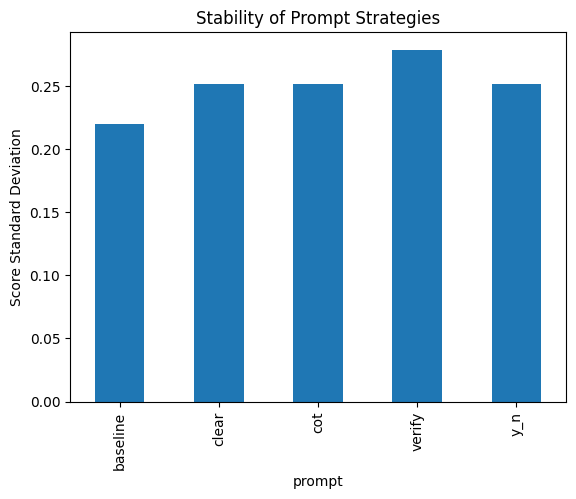

In [16]:
prompt_std = df.groupby("prompt")["score"].std()

plt.figure()
prompt_std.plot(kind="bar")
plt.ylabel("Score Standard Deviation")
plt.title("Stability of Prompt Strategies")
plt.show()


This figure reports the standard deviation of accuracy scores across question groups for each prompt strategy, serving as a measure of performance stability.

The baseline prompt exhibits the lowest variance, indicating the most stable behavior across different task types. This suggests that minimal prompting leads to more predictable performance, even if it is not always optimal for specific tasks.

The clear, chain-of-thought, and Yes/No-constrained prompts show moderately higher variance, reflecting increased sensitivity to task characteristics. Their performance improves in some groups but degrades in others.

The verify prompt displays the highest variance, indicating that self-verification is the least stable strategy across groups. While verification may help in certain cases, it can also lead to overthinking or inconsistent reasoning, resulting in larger performance fluctuations.

These results suggest that more sophisticated prompting strategies trade stability for potential task-specific gains.
Taken together, these two analyses reinforce a central conclusion of the study:
Prompt engineering introduces a trade-off between specialization and robustness. While certain prompts can outperform the baseline in narrowly defined scenarios, they tend to be less stable and may underperform in others. The baseline prompt, despite its simplicity, provides the most consistent performance across diverse question types.

This finding supports the view that prompt engineering should be applied selectively and with awareness of task characteristics, rather than assumed to universally improve model performance.